# Calibrating tied meta parameters

## About this document

This document illustrates how to set up a calibration where a global parameterization is set at the catchment level, with scaled values for each subareas. This method helps to keep the degrees of freedom of an optimisation to a minimum.

In [1]:
from swift2.doc_helper import pkg_versions_info

print(pkg_versions_info("This document was generated from a jupyter notebook"))

This document was generated from a jupyter notebook on 2025-05-16 14:19:23.724938
    swift2 2.5.1
    uchronia 2.6.2


## Use case and sample data

This workflow uses for convenience hourly time series data gathered a decade ago. The data comes from the Ovens River catchment, however the provenance is unclear

## Imports


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from cinterop.timeseries import as_timestamp, xr_ts_end
from swift2.doc_helper import (
    configure_daily_gr4j,
    configure_hourly_gr4j,
    create_test_catchment_structure,
    get_free_params,
    gr4j_scaled_parameteriser,
    sample_series,
)
from swift2.parameteriser import (
    create_parameter_sampler,
    create_sce_optim_swift,
    get_default_sce_parameters,
    get_marginal_termination,
    set_calibration_logger,
)
from swift2.simulation import get_state_value, get_subarea_ids, swap_model
from swift2.utils import as_xarray_series, mk_full_data_id, paste
from swift2.vis import OptimisationPlots, plot_two_series

In [4]:
%matplotlib inline

## Data

The sample data for this tutorial are daily series for the Ovens Catchment in Victoria. Daily streamflow was sourced from https://data.water.vic.gov.au/ at Bright (VIC), and rainfall and morton PET were sourced from  https://www.longpaddock.qld.gov.au/silo/point-data/  at Eurobin (VIC). Note that Eurobin is a bit downstream from Bright and perhaps not the "best" point climate data, but this works for this present vignette.


In [5]:
loc_key = "Ovens-Bright"
daily_rain = sample_series(loc_key, "rain")
daily_pet = sample_series(loc_key, "pet")
daily_streamflow_mlday = sample_series(loc_key, "streamflow")

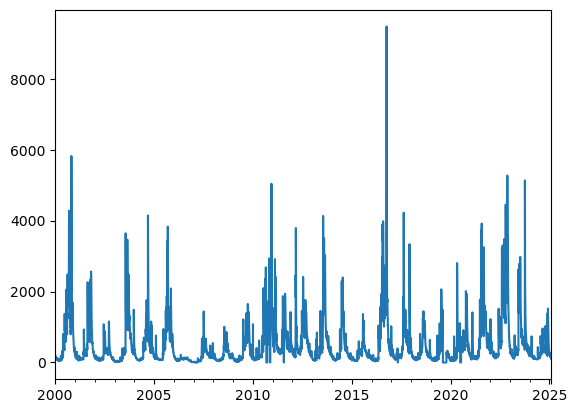

In [6]:
daily_streamflow_mlday.plot();

In [7]:
catchment_area = 495
daily_runoff = daily_streamflow_mlday * 1000 * 1000 / (catchment_area * 1e6)

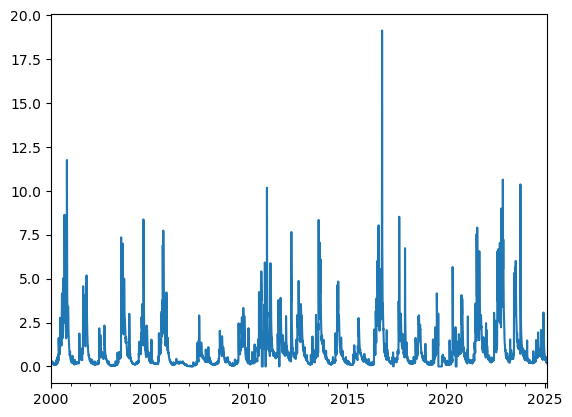

In [8]:
daily_runoff.plot();

In [9]:
daily_cumecs = daily_streamflow_mlday * 1000 / 86400 # ML/day to m3/s

## Creating a synthetic but realistic model

We create a system with total area similar to the real use case, but we use an arbitrary test catchment structure (multiple subareas). This is suitable for this tutorial.

In [10]:
areas_portions = np.array([91, 95, 6, 128, 93]) # arbitrary weights.
areas_portions = areas_portions / sum(areas_portions)
areasKm2 = areas_portions * catchment_area
sum(areasKm2)

np.float64(495.0)

In [11]:
summary, ms = create_test_catchment_structure(areas_km2=areasKm2)

In [12]:
summary

{'node_ids': ['n1', 'n2', 'n3', 'n4', 'n5', 'n6'],
 'node_names': ['n1_name',
  'n2_name',
  'n3_name',
  'n4_name',
  'n5_name',
  'n6_name'],
 'link_ids': ['lnk1', 'lnk2', 'lnk3', 'lnk4', 'lnk5'],
 'link_names': ['lnk1_name',
  'lnk2_name',
  'lnk3_name',
  'lnk4_name',
  'lnk5_name'],
 'from_node': ['n2', 'n5', 'n4', 'n3', 'n1'],
 'to_node': ['n6', 'n2', 'n2', 'n4', 'n4'],
 'areas_km2': array([109.06779661, 113.86198547,   7.19128329, 153.41404358,
        111.46489104]),
 'runoff_model': 'GR4J'}

In [13]:
sum(areasKm2)

np.float64(495.0)

## channel routing

This is besides the main point of this tutorial, but let's take a detour showing how to set up a uniform channel routing using a pure lag routing.

In [14]:
ms = swap_model(ms, "PureLag", "channel_routing")

`PureLag` has a `Tau` parameter that can be a positive floating point value. If we query the variable identifiers of one of the links now:

In [15]:
ms.get_variable_ids('link.lnk1')

['link.lnk1.Length',
 'link.lnk1.f',
 'link.lnk1.ManningsN',
 'link.lnk1.Slope',
 'link.lnk1.LateralInflowRate',
 'link.lnk1.LateralInflowVolume',
 'link.lnk1.Tau',
 'link.lnk1.PreviousUpstreamInflowRate',
 'link.lnk1.PreviousLateralInflowRate',
 'link.lnk1.PreviousOutflowRate',
 'link.lnk1.PreviousStorage',
 'link.lnk1.UpstreamInflowRate',
 'link.lnk1.OutflowRate',
 'link.lnk1.Storage',
 'link.lnk1.InflowRate',
 'link.lnk1.InflowVolume',
 'link.lnk1.AdditionalInflowRate',
 'link.lnk1.AbstractionDemandRate',
 'link.lnk1.AbstractionSuppliedRate',
 'link.lnk1.OutflowVolume']

In [16]:
from swift2.parameteriser import create_parameteriser
p = pd.DataFrame.from_dict({
    "Name": ["Tau"],
    "Value": [0.25],
    "Min": [0.25],
    "Max": [0.25],
})
pure_lag_six_hours = create_parameteriser('generic links', specs=p)

In [17]:
ms.get_state_value('link.lnk1.Tau')

{'link.lnk1.Tau': 0.0}

In [18]:
pure_lag_six_hours.apply_sys_config(ms)

In [19]:
ms.get_state_value('link.lnk1.Tau')

{'link.lnk1.Tau': 0.25}

We will run over a few years and calibrate with a warmup of two years.

## Assign simulation inputs

In [20]:
sa_ids = ms.get_subarea_ids()
rainfall_ids = mk_full_data_id('subarea', sa_ids, "P")
evap_ids = mk_full_data_id('subarea', sa_ids, "E")

In [21]:
ms.get_state_value(rainfall_ids)

{'subarea.lnk1.P': 0.0,
 'subarea.lnk2.P': 0.0,
 'subarea.lnk3.P': 0.0,
 'subarea.lnk4.P': 0.0,
 'subarea.lnk5.P': 0.0}

In [22]:
for rids in rainfall_ids:
    ms.play_input(daily_rain, rids)
for evids in evap_ids:
    ms.play_input(daily_pet, evids)
ms.set_simulation_time_step('daily')

## Define a calibration time span

We define a calibration with objective calculation over 10 years, plus a 2-year warmup period 

In [23]:
e = pd.Timestamp("2024-12-31")

w = e - pd.DateOffset(years=10)
s = w - pd.DateOffset(years=2)

print(f"Calibration run: simulation from {s} to {e}, with a warmup till {w}")

Calibration run: simulation from 2012-12-31 00:00:00 to 2024-12-31 00:00:00, with a warmup till 2014-12-31 00:00:00


The package includes a function that flags possible inconsistencies prior to running a model (inconsistent time steps, etc.)

In [24]:
ms.check_simulation()

{'errors': ['subarea.lnk1.E: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk1.P: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk2.E: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk2.P: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk3.E: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk3.P: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk4.E: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk4.P: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk5.E: End 2025-02-25T00:00:00 < test date not-a-date-time',
  'subarea.lnk5.P: End 2025-02-25T00:00:00 < test date not-a-date-time']}

We need to adjust a couple of parameters for proper operation on hourly data for the GR4 model structure.

Wait what? The message is admitedly not the clearest, but in this case, we have not yet set a the simulation time span

In [25]:
ms.set_simulation_span(s, e)

Now, the check can compare simulation span and time series spans, and finds no problem:

In [26]:
ms.check_simulation()

{'errors': []}

## GR4J (GR4H) modes

GR4J (j for "journalier" i.e. "daily") and GR4H (h for hourly) differ by the values of tso parameters. There are two helper functions to switch modes on all GR4J models in the system

In [27]:
configure_hourly_gr4j(ms)
ms.get_state_value("subarea.lnk1.UHExponent")

{'subarea.lnk1.UHExponent': 1.25}

In [28]:
configure_daily_gr4j(ms)
ms.get_state_value("subarea.lnk1.UHExponent")

{'subarea.lnk1.UHExponent': 2.5}

## Feasible parameter space and parsimony

We have a catchment with 5 subareas, with GR4J. Leaving outside the links which we will not calibrate, this still means 20 parameters overall to calibrate. This can be problematic as there is likely an inflated parameter equifinality (many different combinations leading to sensibly similar performances), and the resulting parameters may not be robust or physically sensible.

Instead, we can define a meta parameter set with only 4 degrees of freedom, with area scaling applied to x4 and time scaling applied to x2 and x3. The time scaling makes it invariant if the simulation time step changes from daily to hourly, but in this sample the most telling scaling is the one for the "lag parameter" `x4`. A single `x4` meta-parameter is reflected in each subarea with values than are scaled according to a function (square root) of the unit's area. Intuitively, it makes sense that the bigger the subarea, the longer the flow routing lag. 

In [29]:
ref_area = 250 # The area for which the scaling of x4 is invariant
time_span = 86400 # The time step of the simulation, one day is 86400 seconds
# time_span = 3600 # if we had an hourly simulation, and hourly inputs 

While it is possible to construct meta-parameterisers from scratch, it is tedious. The GR4J/H scaling strategy is well known and pre-implemented in `gr4j_scaled_parameteriser`

In [30]:
p = gr4j_scaled_parameteriser(ref_area, time_span)

In [31]:
print(p.as_dataframe())

  Name  Value   Min     Max
0   x2    1.0 -27.0    27.0
1   x3   10.0   0.0  1000.0
2   x4   14.0   1.0   240.0
3   x1   44.6   1.0  1000.0


In [32]:
# set x4 bounds to be in "days", not hours
p_x4 = pd.DataFrame.from_dict({
    "Name": ["x4"],
    "Value": [1.0],
    "Min": [0.25],
    "Max": [10.0],
})

In [33]:
p.set_hypercube(p_x4)
p

  Name  Value    Min     Max
0   x2    1.0 -27.00    27.0
1   x3   10.0   0.00  1000.0
2   x4    1.0   0.25    10.0
3   x1   44.6   1.00  1000.0

In [34]:
subarea_ids = paste("subarea", get_subarea_ids(ms), sep=".")
areas = get_state_value(ms, paste(subarea_ids, "areaKm2", sep="."))
areas

{'subarea.lnk1.areaKm2': 109.06779661017,
 'subarea.lnk2.areaKm2': 113.861985472155,
 'subarea.lnk3.areaKm2': 7.1912832929779995,
 'subarea.lnk4.areaKm2': 153.41404358353498,
 'subarea.lnk5.areaKm2': 111.464891041162}

Let us have a look at the values of the `x4` parameters in each subarea, before and after applying this meta-parameteriser `p`

In [35]:
x4_param_ids = paste(subarea_ids, "x4", sep=".")
get_state_value(ms, x4_param_ids)

{'subarea.lnk1.x4': 0.5,
 'subarea.lnk2.x4': 0.5,
 'subarea.lnk3.x4': 0.5,
 'subarea.lnk4.x4': 0.5,
 'subarea.lnk5.x4': 0.5}

In [36]:
p.apply_sys_config(ms)
get_state_value(ms, x4_param_ids)

{'subarea.lnk1.x4': 0.6605082788585469,
 'subarea.lnk2.x4': 0.6748688330991586,
 'subarea.lnk3.x4': 0.16960286899670063,
 'subarea.lnk4.x4': 0.7833620965646346,
 'subarea.lnk5.x4': 0.6677271629675162}

The values of the individual x4 parameters are scaled according to the area of subareas. The larger the catchment, the larger the routing delay, the larger `x4`. The reference area for which the scaling would be 1.0 is 250 km^2, so the closer the catchment area from 250 km^2, the closer to 1.0 the area based scaling.

We can compose a parameter transformation, on top of the tied. It is typical to calibrate on log(x4) rather than x4

In [37]:
p = p.wrap_transform()
p.add_transform("log_x4", "x4", "log10")

In [38]:
p

     Name  Value       Min     Max
0  log_x4    0.0  -0.60206     1.0
1      x2    1.0 -27.00000    27.0
2      x3   10.0   0.00000  1000.0
3      x1   44.6   1.00000  1000.0

In [39]:
outflowVarname = "Catchment.StreamflowRate"
ms.record_state(outflowVarname)

In [40]:
ms.exec_simulation()
calc = ms.get_recorded(outflowVarname)

In [41]:
flow = as_xarray_series(daily_cumecs)

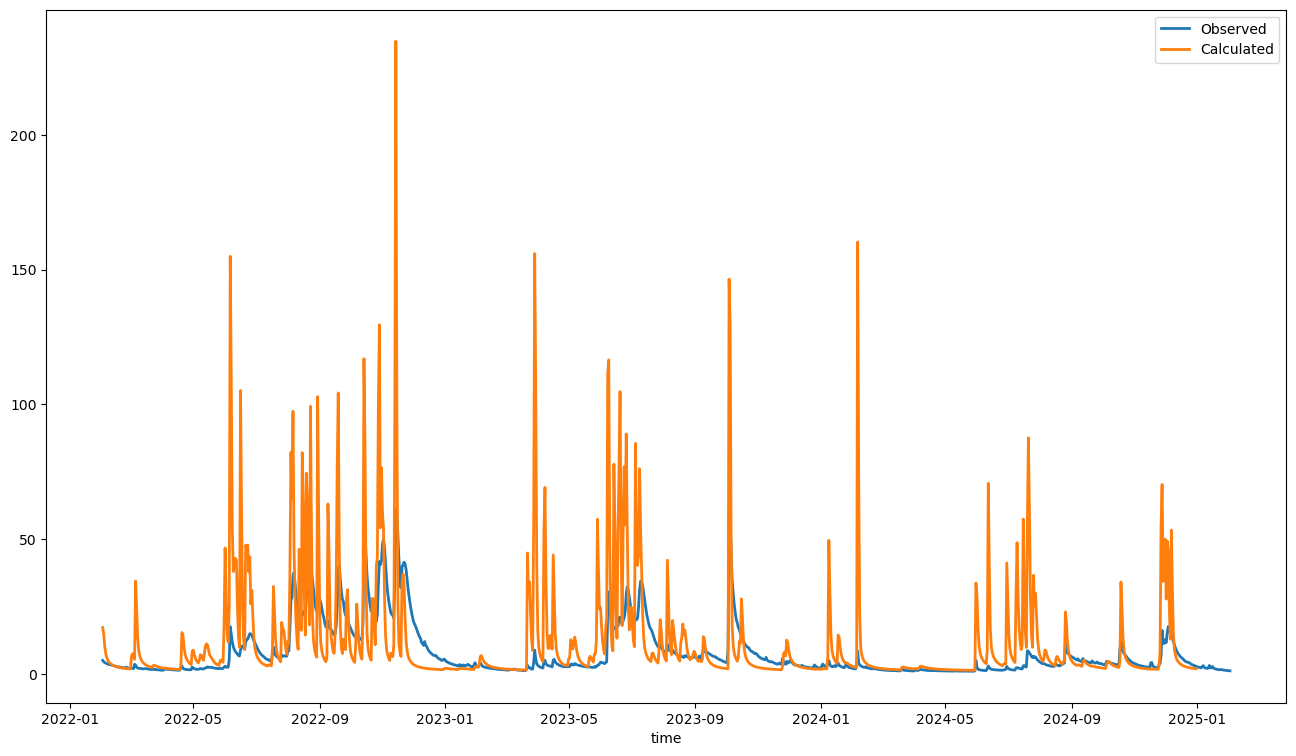

In [42]:
vis_e = as_timestamp(xr_ts_end(flow))
vis_s = vis_e - pd.DateOffset(years=3)

plot_two_series(flow, calc, names=["Observed", "Calculated"], start_time=vis_s, end_time=vis_e)

## Optimiser

Let'c create an NSE evaluator, and check what the default parameter set yields as a goodness of fit.

In [43]:
objective = ms.create_objective(outflowVarname, flow, "NSE", w, e)
score = objective.get_score(p)
print(score)

{'scores': {'NSE': -5.5724317674396335}, 'sysconfig':      Name  Value       Min     Max
0  log_x4    0.0  -0.60206     1.0
1      x2    1.0 -27.00000    27.0
2      x3   10.0   0.00000  1000.0
3      x1   44.6   1.00000  1000.0}


We have our objectives defined, and the parameter space 'p' in which to search. Let's create an optimiser and we are ready to go. While the optimiser can be created in one line, we show how to choose one custom termination criterion and how to configure the optimiser to capture a detailed log of the process.

In [44]:
if "SWIFT_FULL" in os.environ.keys():
    max_hours = 0.2
else:
    max_hours = 0.02

term = get_marginal_termination(tolerance = 1e-05, cutoff_no_improvement = 30, max_hours = max_hours)
# term = get_max_runtime_termination(max_hours=max_hours)
sce_params = get_default_sce_parameters()
urs = create_parameter_sampler(0, p, "urs")
optimiser = create_sce_optim_swift(objective, term, sce_params, urs)
calib_logger = set_calibration_logger(optimiser, "")

At this point you may want to specify the maximum number of cores that can be used by the optimiser, for instance if you wish to keep one core free to work in parallel on something else.

In [45]:
sce_params

{'P': 6,
 'Pmin': 6,
 'M': 9,
 'Q': 7,
 'Alpha': 1,
 'Beta': 9,
 'NumShuffle': 40,
 'TrapezoidalDensityParameter': 1.0,
 'ReflectionRatio': -1.0,
 'ContractionRatio': 0.5}

The number of complexes is 6; by default the optimiser will try to use 6 CPU cores in parallel, or n-1 where N is your number of cores and less than 6. It is possible to limit the level of parallelism if needed, for instance to make sure you have a few cores to work with if an optimiser will run for some time.

In [46]:
optimiser.set_maximum_threads_free_cores(2)

In [47]:
%%time
calib_results = optimiser.execute_optimisation()

CPU times: user 1min 24s, sys: 18.1 ms, total: 1min 24s
Wall time: 16.8 s


Processing the calibration log below. We subset the full log to keep only some types of optimiser messages, in this case we do not keep the "shuffling" stages of the SCE algorithm.

In [48]:
opt_log = optimiser.extract_optimisation_log(fitness_name="NSE")
geom_ops = opt_log.subset_by_message(pattern="Initial.*|Reflec.*|Contrac.*|Add.*")

We can then visualize how the calibration evolved. There are several types of visualisations included in the **mhplot** package, and numerous customizations possible, but starting with the overall population evolution:

In [49]:
geom_ops._data["NSE"].describe()

count    4338.000000
mean        0.244160
std        17.961405
min      -911.455996
25%         0.832471
50%         0.834778
75%         0.834778
max         0.834778
Name: NSE, dtype: float64

In [50]:
p_var_ids = p.as_dataframe().Name.values
p_var_ids

array(['log_x4', 'x2', 'x3', 'x1'], dtype=object)

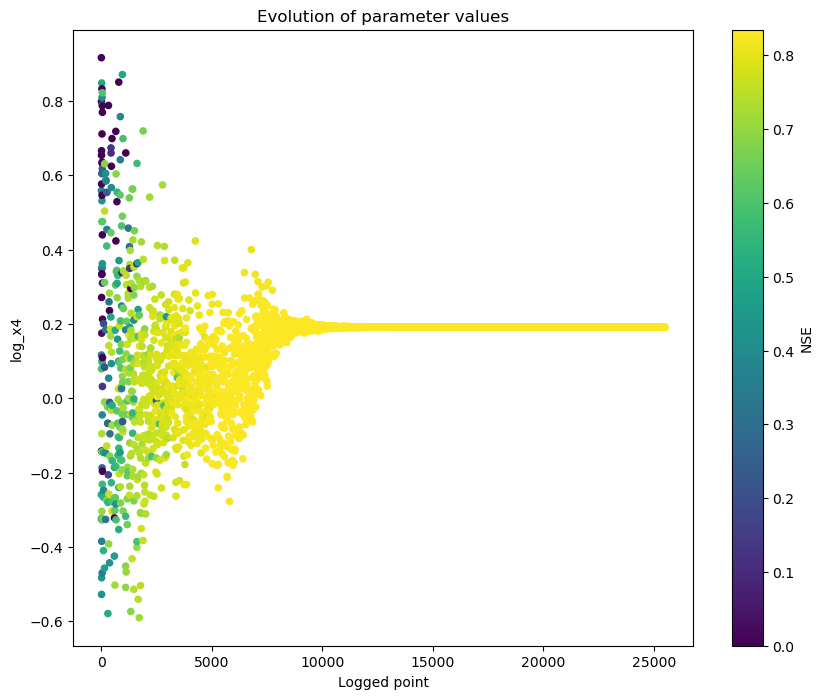

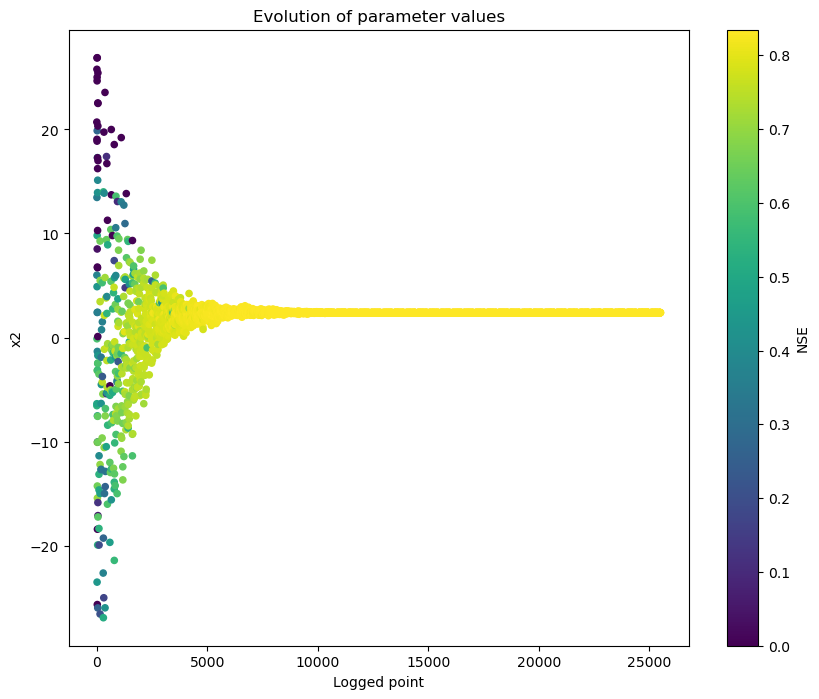

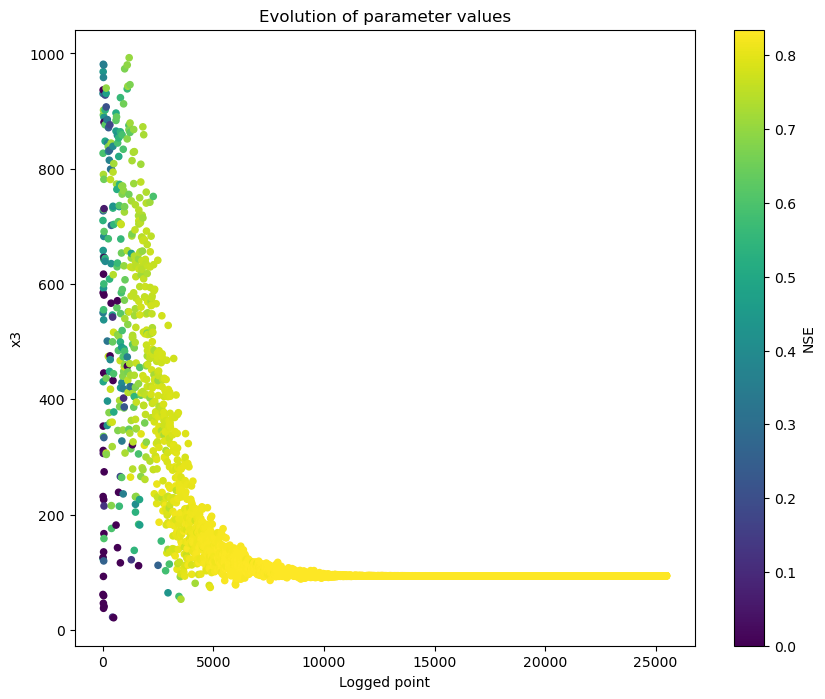

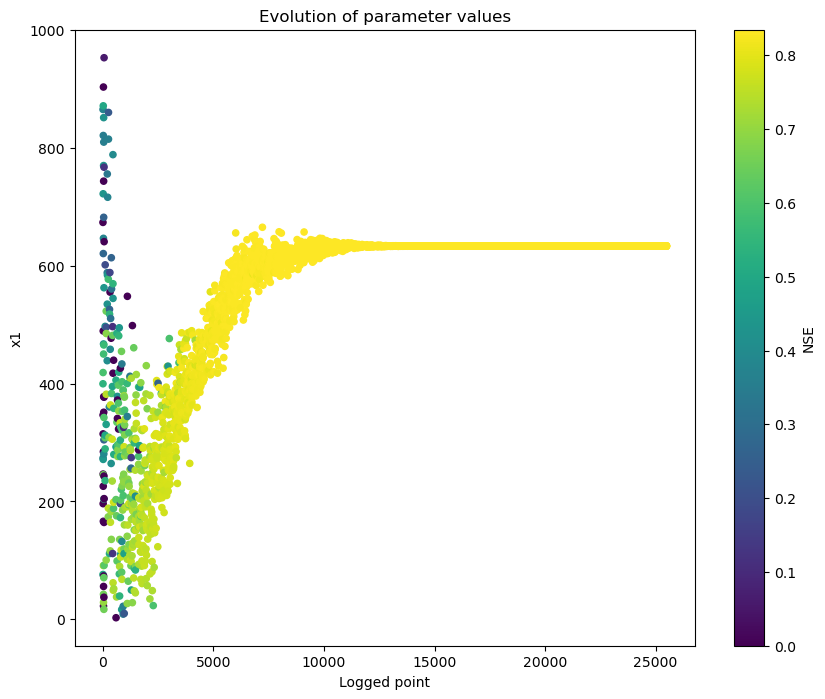

In [51]:
v = OptimisationPlots(geom_ops)
for pVarId in p_var_ids:
    v.parameter_evolution(pVarId, obj_lims=[0, 1])
    plt.gcf().set_size_inches(10, 8)

In [52]:
# sortedResults = sortByScore(calib_results, 'NSE')
# best_pset = getScoreAtIndex(sortedResults, 1)
# best_pset = GetSystemConfigurationWila_R(best_pset)

In [53]:
best_pset = calib_results.get_best_score("NSE").parameteriser

*swift* can back-transform a parameters to obtain the untransformed parameter set(s):

In [54]:
best_pset

     Name       Value       Min     Max
0  log_x4    0.191326  -0.60206     1.0
1      x2    2.389509 -27.00000    27.0
2      x3   93.649563   0.00000  1000.0
3      x1  633.394708   1.00000  1000.0

In [55]:
untfPset = best_pset.backtransform()
score = objective.get_score(best_pset)
score

{'scores': {'NSE': 0.8347778235911274},
 'sysconfig':      Name       Value       Min     Max
 0  log_x4    0.191326  -0.60206     1.0
 1      x2    2.389509 -27.00000    27.0
 2      x3   93.649563   0.00000  1000.0
 3      x1  633.394708   1.00000  1000.0}

In [56]:
score = objective.get_score(untfPset)
score

{'scores': {'NSE': 0.8347778235911274},
 'sysconfig':   Name       Value    Min     Max
 0   x2    2.389509 -27.00    27.0
 1   x3   93.649563   0.00  1000.0
 2   x4    1.553554   0.25    10.0
 3   x1  633.394708   1.00  1000.0}

Finally, let's have a visual of the fitted streamflow data at Bright:

In [57]:
best_pset.apply_sys_config(ms)
ms.exec_simulation()
mod_runoff = ms.get_recorded(outflowVarname)

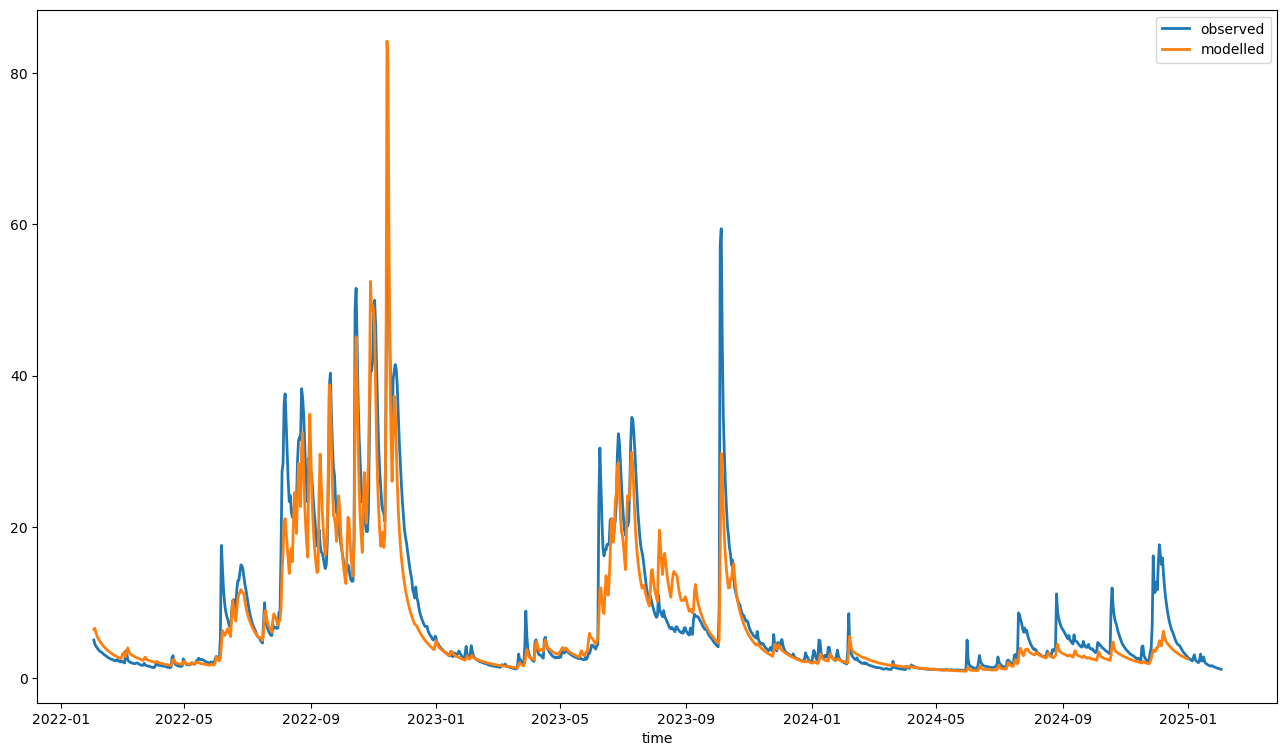

In [58]:
plot_two_series(
    flow, mod_runoff, start_time=vis_s, end_time=vis_e, names=["observed", "modelled"]
)

In [59]:
# runoff = flow / sum(areasKm2)
# runoff.plot()

# plot_two_series(
#     rainfall, runoff, start_time=vis_s, end_time=vis_e, names=["observed rain", "observed runoff"]
# )